In [ ]:
%load_ext nb_black

In [ ]:
import networkx as nx
import random
import numpy as np
from typing import List
from tqdm import tqdm
from gensim.models.word2vec import Word2Vec

import matplotlib.pyplot as plt
from IPython.display import display
from PIL import Image

In [ ]:
# computer transition probabilities


def transition_probabilities(graph, probs, p, q):
    G = graph
    for source_node in G.nodes():
        for current_node in G.neighbors(source_node):
            probs_ = list()
            for destination in G.neighbors(current_node):
                if source_node == destination:
                    prob_ = G[current_node][destination].get("wieght", 1) * (1 / p)
                elif destination in G.neighbors(source_node):
                    prob_ = G[current_node][destination].get("weight", 1)
                else:
                    prob_ = G[current_node][destination].get("weight", 1) * (1 / q)

                probs_.append(prob_)
            probs[source_node]["probabilities"][current_node] = probs_ / np.sum(probs_)

    return probs

In [ ]:
## Baised random walk


def random_walks(graph, probs, num_walks, walk_len):
    G = graph
    walks = list()
    for start_node in G.nodes():
        for i in range(num_walks):
            walk = [start_node]
            walk_options = list(G[start_node])
            if len(walk_options) == 0:
                break
            first_step = np.random.choice(walk_options)
            walk.append(first_step)
            for k in range(walk_len - 2):
                walk_options = list(G[walk[-1]])
                if len(walk_options) == 0:
                    break
                probabilities = probs[walk[-2]]["probabilities"][walk[-1]]
                next_step = np.random.choice(walk_options, p=probabilities)
                walk.append(next_step)
            walks.append(walk)
    np.random.shuffle(walks)
    walks = [list(map(str, walk)) for walk in walks]
    return walks

In [ ]:
def training(walks, window_size, dim):
    model = Word2Vec(sentences=walks, window=window_size, vector_size=dim)

    return model.wv

In [ ]:
import numpy as np
from gensim.models import Word2Vec
import networkx as nx


class GraphEmbedding:
    """
    A class for computing node embeddings from a graph using random walks and Word2Vec.

    Args:
        graph (networkx.Graph): The input graph.
        p (float): Return parameter p for the node2vec algorithm.
        q (float): In-out parameter q for the node2vec algorithm.
        num_walks (int): Number of random walks to perform per node.
        walk_len (int): Length of each random walk.
        window_size (int): The window size for the Word2Vec model.
        dim (int): The dimensionality of the node embeddings.
        negative (int): Number of negative samples to use for negative sampling.

    Attributes:
        graph (networkx.Graph): The input graph.
        p (float): Return parameter p for the node2vec algorithm.
        q (float): In-out parameter q for the node2vec algorithm.
        num_walks (int): Number of random walks to perform per node.
        walk_len (int): Length of each random walk.
        window_size (int): The window size for the Word2Vec model.
        dim (int): The dimensionality of the node embeddings.
        negative (int): Number of negative samples to use for negative sampling.
        probs (dict): Store transition probabilities.
    """

    def __init__(self, graph, p, q, num_walks, walk_len, window_size, dim, negative):
        self.graph = graph
        self.p = p
        self.q = q
        self.num_walks = num_walks
        self.walk_len = walk_len
        self.window_size = window_size
        self.dim = dim
        self.negative = negative
        self.probs = None  # Store transition probabilities

    def transition_probabilities(self):
        """
        Compute transition probabilities for random walks on the graph.

        Returns:
            dict: A dictionary containing the transition probabilities for each node.
        """
        G = self.graph
        probs = {}

        for source_node in G.nodes():
            probs[source_node] = {"probabilities": {}}
            for current_node in G.neighbors(source_node):
                probs_ = list()
                for destination in G.neighbors(current_node):
                    if source_node == destination:
                        prob_ = G[current_node][destination].get("weight", 1) * (
                            1 / self.p
                        )
                    elif destination in G.neighbors(source_node):
                        prob_ = G[current_node][destination].get("weight", 1)
                    else:
                        prob_ = G[current_node][destination].get("weight", 1) * (
                            1 / self.q
                        )

                    probs_.append(prob_)
                probs[source_node]["probabilities"][current_node] = probs_ / np.sum(
                    probs_
                )

        self.probs = probs  # Store transition probabilities
        return probs
    

    def random_walks(self):
        """
        Generate random walks on the graph.

        Returns:
            list: A list of random walks as sequences of node IDs.
        """
        G = self.graph
        walks = list()
        num_nodes = len(G.nodes())
        S = np.zeros((num_nodes, num_nodes))  # Initialize the similarity matrix


        for start_node in G.nodes():
            for i in range(self.num_walks):
                walk = [start_node]
                walk_options = list(G[start_node])

                if len(walk_options) == 0:
                    break

                first_step = np.random.choice(walk_options)
                walk.append(first_step)

                for k in range(self.walk_len - 2):
                    walk_options = list(G[walk[-1]])

                    if len(walk_options) == 0:
                        break

                    probabilities = self.probs[walk[-2]]["probabilities"][walk[-1]]
                    next_step = np.random.choice(walk_options, p=probabilities)
                    walk.append(next_step)

                walks.append(walk)
                # Update the similarity matrix
                for node_j in G.nodes():
                    if node_j == start_node:
                        S[start_node][node_j] = 1.000  # Probability of visiting itself is 1
                    elif node_j not in walk:
                        S[start_node][node_j] = 0.000  # Probability of not visiting is 0
                    else:
                        # Calculate the probability of visiting node_j during the walk
                        prob_ij = walk.count(node_j) / (self.walk_len - 1)
                        S[start_node][node_j] += prob_ij
        np.random.shuffle(walks)
        walks = [list(map(str, walk)) for walk in walks]

        return walks, S


    def train_embedding(self, walks, dim=None, window_size=None, negative=None):
        """
        Train node embeddings using Word2Vec.

        Args:
            walks (list): List of random walks.
            dim (int, optional): The dimensionality of the node embeddings. If None, use the class's dim.
            window_size (int, optional): The window size for the Word2Vec model. If None, use the class's window_size.
            negative (int, optional): Number of negative samples to use for negative sampling.
                If None, use the class's negative value.

        Returns:
            gensim.models.keyedvectors.KeyedVectors: Trained Word2Vec model.
        """
        if dim is None:
            dim = self.dim
        if window_size is None:
            window_size = self.window_size
        if negative is None:
            negative = self.negative

        model = Word2Vec(
            sentences=walks,
            window=window_size,
            vector_size=dim,
            sg=1,
            negative=negative,
        )
        return model.wv

In [ ]:
# Define your objective function
def loss_function(params):
    (
        dimensions,
        walk_length,
        num_walks,
        p,
        q,
        learning_rate,
        window_size,
        epochs,
        negative_samples,
        batch_size,
    ) = params

    # Create and train the Node2Vec model
    node2vec_model = Node2Vec(
        G,
        int(dimensions),
        int(walk_length),
        int(num_walks),
        p,
        q,
        learning_rate,
        int(window_size),
        int(epochs),
        int(negative_samples),
    )
    node2vec_model.train(int(batch_size))
    S = node2vec_model.compute_similarity_matrix()

    # Calculate the objective function value
    embeddings = node2vec_model.get_embeddings()
    Z_transpose = np.transpose(embeddings)
    diff = np.dot(Z_transpose, embeddings) - S
    #     loss_func = np.linalg.norm(diff) ** 2
    loss_func = np.linalg.norm(diff)
    return loss_func

In [ ]:
G = nx.karate_club_graph()

In [ ]:
G

In [ ]:
# from collections import defaultdict

# probs = defaultdict(dict)


In [ ]:
# for node in G.nodes():
#     #     print(node)
#     probs[node]["probabilities"] = dict()

In [ ]:
embedding = GraphEmbedding(
    G, p=3.5, q=1.5, num_walks=10, walk_len=10, window_size=5, dim=8, negative=6
)

In [ ]:
# Compute transition probabilities
probs = embedding.transition_probabilities()

In [ ]:
probs

In [ ]:
# Generate random walks
walks, S = embedding.random_walks()

In [ ]:
walks

In [ ]:
S[0]

In [ ]:
S[1]

In [ ]:
S[33]

In [ ]:
len(walks)

In [ ]:
def loss_function(Z, S):
    """
    Calculate the objective function ||Z^T*Z - S||^2.

    Args:
        Z (numpy.ndarray): The node embeddings as a numpy array.
        S (numpy.ndarray): The similarity matrix.

    Returns:
        float: The value of the objective function.
    """
    Z_transpose = np.transpose(Z)
    diff = np.dot(Z_transpose, Z) - S
    #     obj_func = np.linalg.norm(diff) ** 2
    obj_func = np.linalg.norm(diff)
    return obj_func

In [ ]:
los = loss_function(all_emb, S)

In [ ]:
los

In [ ]:
Z_transpose = np.transpose(all_emb)

In [ ]:
all_emb

In [ ]:
all_emb.shape

In [ ]:
S.shape

In [ ]:
# Train node embeddings using Word2Vec with custom dimensions, window size, and negative sampling
node_embeddings = embedding.train_embedding(walks, dim=20, window_size=5, negative=6)

In [ ]:
node_embeddings.

In [ ]:
all_emb = node_embeddings.vectors.T

In [ ]:
# Get the number of nodes in the graph
num_nodes = len(G.nodes())

In [ ]:
similarity_matrix[0]

In [ ]:
walks

In [ ]:
cp = transition_probabilities(G, probs, 1, 0.5)

In [ ]:
G.neighbors

In [ ]:
cp

In [ ]:
walks = random_walks(G, cp, 10, 20)


# model = Node2Vec(
#     walk_length=20, dimensions=20, p=1.0, q=0.5, window_size=20, walk_number=10
# )

In [ ]:
len(walks)

In [ ]:
walks

In [ ]:
emb = training(walks, 20, 20)

In [ ]:
myyemb = emb.vectors

In [ ]:
emb.vectors.shape

## classification 

In [ ]:
import numpy as np
import pandas as pd
import networkx as nx
import torch_geometric
import torch

In [ ]:
from karateclub import Node2Vec

In [ ]:
model = Node2Vec(
    walk_length=20, dimensions=20, p=1.0, q=0.5, window_size=20, walk_number=10
)

In [ ]:
model.fit(G)

In [ ]:
embed = model.get_embedding()

In [ ]:
embed

In [ ]:
embed.shape

In [ ]:
club_labels = nx.get_node_attributes(G, "club")

In [ ]:
club_labels

In [ ]:
y = np.array(list(club_labels.values()))

In [ ]:
y

In [ ]:
y.shape

In [ ]:
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    f1_score,
)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    embed, y, test_size=0.2, random_state=42
)

In [ ]:
X_train.shape

In [ ]:
logreg = LogisticRegression()

In [ ]:
logreg.fit(X_train, y_train)

In [ ]:
y_pred = logreg.predict(X_test)

In [ ]:
y_pred

In [ ]:
print(classification_report(y_test, y_pred))

In [ ]:
X_train_d, X_test_d, y_train_d, y_test_d = train_test_split(
    myyemb, y, test_size=0.2, random_state=42
)

In [ ]:
myyemb.shape

In [ ]:
logreg_d = LogisticRegression()

In [ ]:
logreg_d.fit(X_train_d, y_train_d)

In [ ]:
y_pred_d = logreg_d.predict(X_test_d)

In [ ]:
y_pred_d

In [ ]:
print(classification_report(y_test_d, y_pred_d))

In [ ]:
import os
import collections
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.sparse as sp
import torch
from torch import Tensor
import random
import torch_geometric
from torch_geometric.utils import to_networkx
from torch_geometric.datasets import Planetoid
import networkx as nx
from networkx.algorithms import community
import numpy as np
from gensim.models import Word2Vec
import networkx as nx
import random

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data_dir = "Data/"
os.makedirs(data_dir, exist_ok=True)
SEED = 42

In [ ]:
dataset = Planetoid(root=data_dir, name="Cora")
data = dataset[0]

In [ ]:
G = to_networkx(data, to_undirected=True)

In [ ]:
import networkx as nx
import random
import numpy as np
from typing import List
from tqdm import tqdm
from gensim.models.word2vec import Word2Vec

import matplotlib.pyplot as plt
from IPython.display import display
from PIL import Image

In [ ]:
from node_random.randomwalk import GraphEmbedding

In [ ]:
G = nx.karate_club_graph()

In [ ]:
# # graph, return_param, in_out_param, num_walks, walk_length, window_size, embedding_dimension, negative_samples

# Best Hyperparameters: {'return_param': 0.780188065757644, 'in_out_param': 1.0504386209768906, 
# 'num_walks': 6, 'walk_length': 11, 'window_size': 7, 'dimension': 128, 'epochs': 100, 'negative': 5, 'batch_words': 100}
# Best Loss: 62.610528542536336

In [ ]:
embedding = GraphEmbedding(
    graph=G,
    return_param=0.78,
    in_out_param=1.05,
    num_walks=10,
    walk_length=5,
)

In [ ]:
probab = embedding.calculate_transition_probabilities()

In [ ]:
len(probab)

In [ ]:
# Determine the size of the square matrix
num_nodes = len(probab)

# Initialize an empty square matrix
transition_matrix = np.zeros((num_nodes, num_nodes))

# Fill in the matrix with transition probabilities
for i in range(num_nodes):
    for j in range(num_nodes):
        # Check if there are probabilities defined for this transition
        if j in probab[i]['probabilities']:
            transition_matrix[i][j] = sum(probab[i]['probabilities'][j])

In [ ]:
# Normalize the rows of the matrix to ensure they sum to 1
row_sums = transition_matrix.sum(axis=1)
transition_matrix_normalized = transition_matrix / row_sums[:, np.newaxis]

In [ ]:
transition_matrix_normalized[0]

In [ ]:
transition_matrix_normalized[5]

In [ ]:
walks, unsh = embedding.generate_random_walks()

In [ ]:
unsh

In [ ]:
def calculate_probability_matrix(random_walks,num_walks,walk_length):
    num_nodes = len(random_walks) // num_walks
    prob_matrix = np.zeros((num_nodes, num_nodes))

    visited_nodes = [set() for _ in range(len(random_walks))]

    for i, walk_i in enumerate(random_walks):
        for step in range(walk_length):
            visited_nodes[i].add(walk_i[step])

    def compute_probability(i, j):
        if i == j:
            return 1.0

        common_count = 0

        for k in range(num_walks):
            common_count += len(visited_nodes[i].intersection(visited_nodes[j]))

        return common_count / num_walks

    with concurrent.futures.ThreadPoolExecutor() as executor:
        futures = []
        for i in tqdm(range(num_nodes), desc="Calculating Probabilities"):
            for j in range(num_nodes):
                futures.append(executor.submit(compute_probability, i, j))

        for i in tqdm(range(num_nodes * num_nodes), desc="Collecting Results"):
            row = i // num_nodes
            col = i % num_nodes
            prob_matrix[row, col] = futures[i].result()

    return prob_matrix

In [ ]:
prob_matrix = embedding.calculate_probability_matrix(unsh)


In [ ]:
prob_matrix[0]

In [ ]:
probability_matrix = calculate_probability_matrix(unsh, 10,5)

# Convert the probability_matrix to a NumPy array
probability_matrix = np.array(probability_matrix)

In [ ]:
probability_matrix

In [ ]:
def calculate_probability(list, num_walks, length):
  """
  Calculates the probability of visiting a node j when started from node i.

  Args:
    list: A list of lists, where each sublist represents a random walk.
    num_walks: The number of walks in the list.
    length: The length of each walk.

  Returns:
    A list of lists, where each sublist contains the probabilities of visiting each node
    when started from the corresponding node in the input list.
  """

  num_nodes = len(list[0])
  prob = [[0 for _ in range(num_nodes)] for _ in range(num_nodes)]

  for i in range(num_walks):
    for j in range(length):
      if len(list[i]) >= j + 1:
        prob[list[i][0]][list[i][j]] += 1

  for i in range(num_nodes):
    for j in range(num_nodes):
      if i == j:
        prob[i][j] = 1
      else:
        prob[i][j] /= num_walks

  return prob

In [ ]:
def calculate_probability_matrix(random_walks, num_walks):
    # Convert strings to integers in the random_walks list
    random_walks = [[int(node) for node in walk] for walk in random_walks]

    # Determine the number of nodes
    num_nodes = max(max(walk) for walk in random_walks)

    # Initialize the probability matrix with zeros using NumPy
    prob_matrix = np.zeros((num_nodes, num_nodes))

    # Count the number of times each node is visited from each starting node
    visit_counts = np.zeros((num_nodes, num_nodes), dtype=int)
    start_counts = np.zeros(num_nodes, dtype=int)

    for walk in random_walks:
        start_node = walk[0]
        visited_nodes = set(walk[1:])  # Use a set to keep track of visited nodes in each walk
        start_counts[start_node - 1] += 1
        for visited_node in visited_nodes:
            visit_counts[start_node - 1][visited_node - 1] += 1

    # Calculate the probabilities based on the counts
    for i in range(num_nodes):
        for j in range(num_nodes):
            if i == j:
                prob_matrix[i][j] = 1.0
            else:
                prob_matrix[i][j] = visit_counts[i][j] / start_counts[i] * num_walks

    return prob_matrix

In [ ]:
def calculate_probability_matrix(random_walks, num_walks):
    # Convert strings to integers in the random_walks list
    random_walks = [[int(node) for node in walk] for walk in random_walks]

    # Determine the number of nodes
    num_nodes = max(max(walk) for walk in random_walks)

    # Initialize the probability matrix with zeros
    prob_matrix = [[0.0] * num_nodes for _ in range(num_nodes)]

    # Count the number of times each node is visited from each starting node
    for start_node, *visited_nodes in random_walks:
        for visited_node in visited_nodes:
            prob_matrix[start_node - 1][visited_node - 1] += 1

    # Calculate the probabilities based on the counts
    for i in range(num_nodes):
        for j in range(num_nodes):
            if i == j:
                prob_matrix[i][j] = 1.0
            else:
                prob_matrix[i][j] /= num_walks

    return prob_matrix

# Example usage:
random_walks = [
    ['1', '2', '3'],
    ['1', '2', '4'],
    ['2', '1', '3'],
    ['2', '4', '2'],
    ['3', '1', '4'],
    ['3', '1', '2'],
    ['4', '1', '3'],
    ['4', '2', '1']
]
num_walks = 2

probability_matrix = calculate_probability_matrix(random_walks, num_walks)
for row in probability_matrix:
    print(row)


In [ ]:
calculate_probability_matrix(unsh,len(G.nodes()))

In [ ]:
S = embedding.calculate_probability_matrix(unsh)

In [ ]:
S[0]

In [ ]:
S[1]

In [ ]:
def generate_probability_matrix(unshuffled_random_walks, num_nodes, max_walk_length):
    probability_matrix = np.zeros((num_nodes, num_nodes), dtype=np.float32)

    def update_probability_matrix(walk):
        start_node = int(walk[0])
        for j in range(1, len(walk)):
            node_j = int(walk[j])
            for t in range(1, max_walk_length + 1):
                if j + t < len(walk):
                    node_i = int(walk[j + t])
                    probability_matrix[node_i, node_j] += 1.0

    for walk in tqdm(unshuffled_random_walks, desc="Generating Probability Matrix"):
        update_probability_matrix(walk)

    # Normalize the probability matrix by dividing each entry by the total number of walks
#     probability_matrix /= len(unshuffled_random_walks)

    return probability_matrix

In [ ]:
def calculate_probability_matrix(unshuffled_random_walks, num_nodes, max_walk_length):
    probability_matrix = np.zeros((num_nodes, num_nodes), dtype=np.float32)
    count_matrix = np.zeros((num_nodes, num_nodes), dtype=np.float32)

    for walk in tqdm(unshuffled_random_walks, desc="Calculating Probability Matrix"):
        for i in range(len(walk)):
            for j in range(i + 1, min(i + max_walk_length + 1, len(walk))):
                node_i = int(walk[i])
                node_j = int(walk[j])
                count_matrix[node_i, node_j] += 1

    for i in range(num_nodes):
        for j in range(i + 1, num_nodes):
            if count_matrix[i, i] > 0:
                probability_matrix[i, j] = count_matrix[i, j] / count_matrix[i, i]
            if count_matrix[j, j] > 0:
                probability_matrix[j, i] = count_matrix[j, i] / count_matrix[j, j]

    # Set the diagonal elements to 1.0
    np.fill_diagonal(probability_matrix, 1.0)

    return probability_matrix

In [ ]:
probability_matrix = calculate_probability_matrix(unsh, len(G.nodes()), max_walk_length=5)


In [ ]:
probability_matrix.shape

In [ ]:
probability_matrix[0]

In [ ]:
probability_matrix[1]

In [ ]:
import numpy as np
from tqdm import tqdm
from scipy.sparse import lil_matrix

In [ ]:
probability_matrix = generate_probability_matrix(unsh, len(G.nodes()), max_walk_length=5)


In [ ]:
probability_matrix[0]

In [ ]:
len(G.nodes())

In [ ]:
# train_embedding(self, walks, dim=None, window_size=None, negative=None)
# training(walks, window_size, dim):

In [ ]:
# Train node embeddings using Word2Vec with custom dimensions, window size, and negative sampling
# Train node embeddings using Word2Vec with custom dimensions, window size, and negative sampling
window_size = 10  # Set your desired window size
dimension = 128  # Set your desired dimension
epochs = 200
negative=6

batch_words=128


node_embeddings = embedding.training(
    walks, window_size=window_size, dimension=dimension, sg=1,epochs=epochs,negative=negative,batch_words=batch_words
)

In [ ]:
Z = node_embeddings.vectors.T

In [ ]:
def loss_function(Z, S):
    """
    Calculate the objective function ||Z^T*Z - S||^2.

    Args:
        Z (numpy.ndarray): The node embeddings as a numpy array.
        S (numpy.ndarray): The similarity matrix.

    Returns:
        float: The value of the objective function.
    """
    Z_transpose = np.transpose(Z)
    diff = np.dot(Z_transpose, Z) - S
    #     obj_func = np.linalg.norm(diff) ** 2
    obj_func = np.linalg.norm(diff)
    return obj_func

In [ ]:
loss_function(Z, probability_matrix)

### Hypertuning

In [ ]:
# Define the hyperparameter search space
param_space = {
    'return_param': np.random.uniform(0.1, 4.0, 10),  # Example: random uniform sampling
    'in_out_param': np.random.uniform(0.1, 4.0, 10),  # Example: random uniform sampling
    'num_walks': np.random.randint(5, 15, 8),  # Example: random integer sampling
    'walk_length': np.random.randint(50, 100,10),  # Example: random integer sampling
    'window_size': np.random.randint(5, 15, 5),  # Example: random integer sampling
    'dimension': np.random.choice([32,64,16,128,48], 6),  # Example: random choice
    'epochs': np.random.choice([50, 75, 100,125,150,200], 5),  # Example: random choice
    'negative': np.random.choice([5, 10], 5),  # Example: random choice
    'batch_words': np.random.choice([100, 500], 5),  # Example: random choice
}

best_loss = float('inf')
best_params = None

In [ ]:
# Perform random search
num_iterations = 10  # Adjust the number of iterations as needed


In [ ]:
for _ in range(num_iterations):
    # Randomly sample hyperparameters
    sampled_params = {param: np.random.choice(values) for param, values in param_space.items()}
    
    # Create an instance of your GraphEmbedding class with sampled hyperparameters
    embedding = GraphEmbedding(
        graph=G,
        return_param=sampled_params['return_param'],
        in_out_param=sampled_params['in_out_param'],
        num_walks=sampled_params['num_walks'],
        walk_length=sampled_params['walk_length'],
    )
    
    probab = embedding.calculate_transition_probabilities()
    # Train and evaluate with the current set of hyperparameters
    walks, S = embedding.generate_random_walks()
    node_embeddings = embedding.training(
        walks,
        window_size=sampled_params['window_size'],
        dimension=sampled_params['dimension'],
        sg=1,
        epochs=sampled_params['epochs'],
        negative=sampled_params['negative'],
        batch_words=sampled_params['batch_words']
    )
    Z = node_embeddings.vectors.T
    current_loss = loss_function(Z, S)
    
    # Update the best hyperparameters if the current set is better
    if current_loss < best_loss:
        best_loss = current_loss
        best_params = sampled_params

In [ ]:
print("Best Hyperparameters:", best_params)
print("Best Loss:", best_loss)

In [ ]:
def calculate_probability_matrix(random_walks, num_walks, walk_length):
    # Convert strings to integers in the random_walks list
    random_walks = [[int(node) for node in walk] for walk in random_walks]

    # Determine the number of nodes
    num_nodes = max(max(walk) for walk in random_walks)

    # Initialize the probability matrix with zeros using NumPy
    prob_matrix = np.zeros((num_nodes, num_nodes))

    # Count the number of times each node is uniquely visited starting from each node
    unique_visit_counts = np.zeros((num_nodes, num_nodes), dtype=int)

    for walk in random_walks:
        start_node = walk[0]
        visited_nodes = set(walk[0:walk_length])  # Consider only the first 'walk_length' nodes
        for visited_node in visited_nodes:
            unique_visit_counts[start_node - 1][visited_node - 1] += 1

    # Calculate the probabilities based on the counts and number of walks
    for i in range(num_nodes):
        for j in range(num_nodes):
            if i == j:
                prob_matrix[i][j] = 1.0
            else:
                prob_matrix[i][j] = unique_visit_counts[i][j] / num_walks

    return prob_matrix

In [ ]:
random_walks = [[int(node) for node in walk] for walk in unsh]

In [ ]:
num_nodes = max(max(walk) for walk in random_walks)

In [ ]:
unsh

In [ ]:
unique_visit_counts = np.zeros((num_nodes, num_nodes), dtype=int)

In [ ]:
unique_visit_counts[0]

In [ ]:
for walk in random_walks:
    start_node = walk[0]
#     print(start_node)
    visited_nodes = set(walk[0:9])
    print(visited_nodes)
    for visited_node in visited_nodes:
#         print(visited_node)
        unique_visit_counts[start_node-1][visited_node-1] += 1

In [ ]:
start_node

In [ ]:
def calculate_probability_matrix(random_walks, num_walks, walk_length):
    num_nodes = len(random_walks) // num_walks
    prob_matrix = np.zeros((num_nodes, num_nodes))
    
    for i in range(num_nodes):
        for j in range(num_nodes):
            if i == j:
                prob_matrix[i, j] = 1
            else:
                common_count = 0
                
                for k in range(num_walks):
                    walk_i = random_walks[i * num_walks + k]
                    walk_j = random_walks[j * num_walks + k]
                    
                    visited_nodes_i = set()
                    visited_nodes_j = set()
                    
                    for step in range(walk_length):
                        visited_nodes_i.add(walk_i[step])
                        visited_nodes_j.add(walk_j[step])
                    
                    common_nodes = visited_nodes_i.intersection(visited_nodes_j)
                    
                    if str(j) in common_nodes:
                        common_count += 1
                    
                prob_matrix[i, j] = common_count / num_walks
    
    return prob_matrix

In [ ]:
unsh

In [ ]:
prob_matrix = calculate_probability_matrix(unsh, 10, 5)
print(prob_matrix)

In [ ]:
prob_matrix[0]

In [ ]:
import numpy as np
from collections import Counter

def calculate_probability_matrix(random_walks, num_walks, walk_length):
    num_nodes = len(random_walks) // num_walks
    prob_matrix = np.zeros((num_nodes, num_nodes))

    for i in range(num_nodes):
        for j in range(num_nodes):
            if i == j:
                prob_matrix[i, j] = 1
            else:
                count_i = Counter()
                count_j = Counter()
                
                for k in range(num_walks):
                    walk_i = random_walks[i * num_walks + k]
                    walk_j = random_walks[j * num_walks + k]
                    
                    for step in range(walk_length):
                        count_i[walk_i[step]] += 1
                        count_j[walk_j[step]] += 1
                
                common_elements = set(count_i.keys()) & set(count_j.keys())
                prob = sum(min(count_i[element], count_j[element]) for element in common_elements) / num_walks
                prob_matrix[i, j] = prob

    return prob_matrix

# Example random_walks
random_walks = [
    ['1', '2', '3'],
    ['1', '2', '4'],
    ['2', '1', '3'],
    ['2', '4', '2'],
    ['3', '1', '4'],
    ['3', '1', '2'],
    ['4', '1', '4'],
    ['4', '2', '1']
]

num_walks = 2
walk_length = 3

# Calculate the probability matrix
probability_matrix = calculate_probability_matrix(random_walks, num_walks, walk_length)
print(probability_matrix)


In [ ]:
import numpy as np
from collections import Counter

def calculate_probability_matrix(random_walks, num_walks, walk_length):
    num_nodes = len(random_walks) // num_walks
    prob_matrix = np.zeros((num_nodes, num_nodes))

    for i in range(num_nodes):
        for j in range(num_nodes):
            if i == j:
                prob_matrix[i, j] = 1
            else:
                count_i = Counter()
                count_j = Counter()
                
                for k in range(num_walks):
                    walk_i = random_walks[i * num_walks + k]
                    walk_j = random_walks[j * num_walks + k]
                    
                    # Count unique visits within the same walk
                    unique_elements_i = set()
                    unique_elements_j = set()
                    
                    for step in range(walk_length):
                        unique_elements_i.add(walk_i[step])
                        unique_elements_j.add(walk_j[step])
                    
                    common_elements = unique_elements_i.intersection(unique_elements_j)
                    
                    # Count the number of unique common elements between the walks
                    common_count = len(common_elements)
                    
                    count_i[common_count] += 1
                    count_j[common_count] += 1
                
                prob = sum(min(count_i[element], count_j[element]) * element for element in count_i.keys()) / num_walks
                prob_matrix[i, j] = prob

    return prob_matrix

# Example random_walks
random_walks = [
    ['1', '2', '3'],
    ['1', '2', '4'],
    ['2', '1', '3'],
    ['2', '4', '2'],
    ['3', '1', '4'],
    ['3', '1', '2'],
    ['4', '1', '4'],
    ['4', '2', '1']
]

num_walks = 2
walk_length = 3

# Calculate the probability matrix
probability_matrix = calculate_probability_matrix(random_walks, num_walks, walk_length)
print(probability_matrix)


In [ ]:
num_nodes = len(random_walks) // num_walks
prob_matrix = np.zeros((num_nodes, num_nodes))

In [ ]:
prob_matrix

In [ ]:
num_nodes

In [ ]:
for i in range(num_nodes):
    for j in range(num_nodes):
        if i == j:
            prob_matrix[i, j] = 1
        else:
            count_i = Counter()
            count_j = Counter()
            print(co)

In [ ]:
import numpy as np
from collections import Counter


num_nodes = len(random_walks) // num_walks
prob_matrix = np.zeros((num_nodes, num_nodes))

for i in range(num_nodes):
    for j in range(num_nodes):
        if i == j:
            prob_matrix[i, j] = 1
        else:
            count_i = Counter()
            count_j = Counter()

            for k in range(num_walks):
                walk_i = random_walks[i * num_walks + k]
                print(walk_i)
                walk_j = random_walks[j * num_walks + k]

                visited_nodes_i = set()
                visited_nodes_j = set()

                for step in range(walk_length):
                    visited_nodes_i.add(walk_i[step])
                    visited_nodes_j.add(walk_j[step])

                common_nodes = visited_nodes_i.intersection(visited_nodes_j)
                count_i.update(common_nodes)
                count_j.update(common_nodes)

            common_count = sum(min(count_i[element], count_j[element]) for element in count_i.keys())
            prob_matrix[i, j] = common_count / num_walks

# return prob_matrix


In [ ]:

import numpy as np

def calculate_probability_matrix(random_walks, num_walks, walk_length):
    num_nodes = len(random_walks) // num_walks
    prob_matrix = np.zeros((num_nodes, num_nodes))

    for i in range(num_nodes):
        for j in range(num_nodes):
            if i == j:
                prob_matrix[i, j] = 1
            else:
                common_count = 0

                for k in range(num_walks):
                    walk_i = random_walks[i * num_walks + k]
                    walk_j = random_walks[j * num_walks + k]

                    # Create sets to keep track of visited nodes in each walk
                    visited_nodes_i = set()
                    visited_nodes_j = set()

                    for step in range(walk_length):
                        visited_nodes_i.add(walk_i[step])
                        visited_nodes_j.add(walk_j[step])

                    common_nodes = visited_nodes_i.intersection(visited_nodes_j)

                    # If the node being considered is a common node, increment the count
                    if str(j + 1) in common_nodes:
                        common_count += 1

                prob_matrix[i, j] = common_count / num_walks

    return prob_matrix

# Example random_walks
random_walks = [
    ['1', '2', '3','5'],
    ['1', '2', '4','4'],
    ['2', '1', '3','2'],
    ['2', '4', '2','3'],
    ['3', '1', '4','2'],
    ['3', '1', '2','5'],
    ['4', '1', '2','4'],
    ['4', '1', '1','3'],
    ['5', '1', '3','3'],
    ['5', '2', '1','1']
]

num_walks = 2
walk_length = 4

# Calculate the probability matrix
probability_matrix = calculate_probability_matrix(random_walks, num_walks, walk_length)
print(probability_matrix)

In [1]:
import networkx as nx
import matplotlib.pyplot as plt

# Create an empty graph
G = nx.Graph()

# Read graph data from the file
with open('out.moreno_lesmis_lesmis', 'r') as file:
    for line in file:
        if line.startswith('%') or not line.strip():
            continue
        parts = line.split()
        if len(parts) == 3:
            node1, node2, weight = map(int, parts)
            G.add_edge(node1, node2, weight=weight)

In [3]:
G.nodes()

NodeView((1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 24, 25, 26, 27, 28, 29, 30, 32, 33, 34, 35, 36, 37, 38, 39, 44, 45, 49, 50, 52, 56, 59, 65, 69, 70, 71, 72, 73, 17, 18, 19, 20, 21, 22, 23, 31, 42, 43, 51, 40, 41, 76, 55, 46, 53, 58, 63, 47, 48, 60, 61, 62, 64, 66, 67, 74, 75, 77, 57, 54, 68))

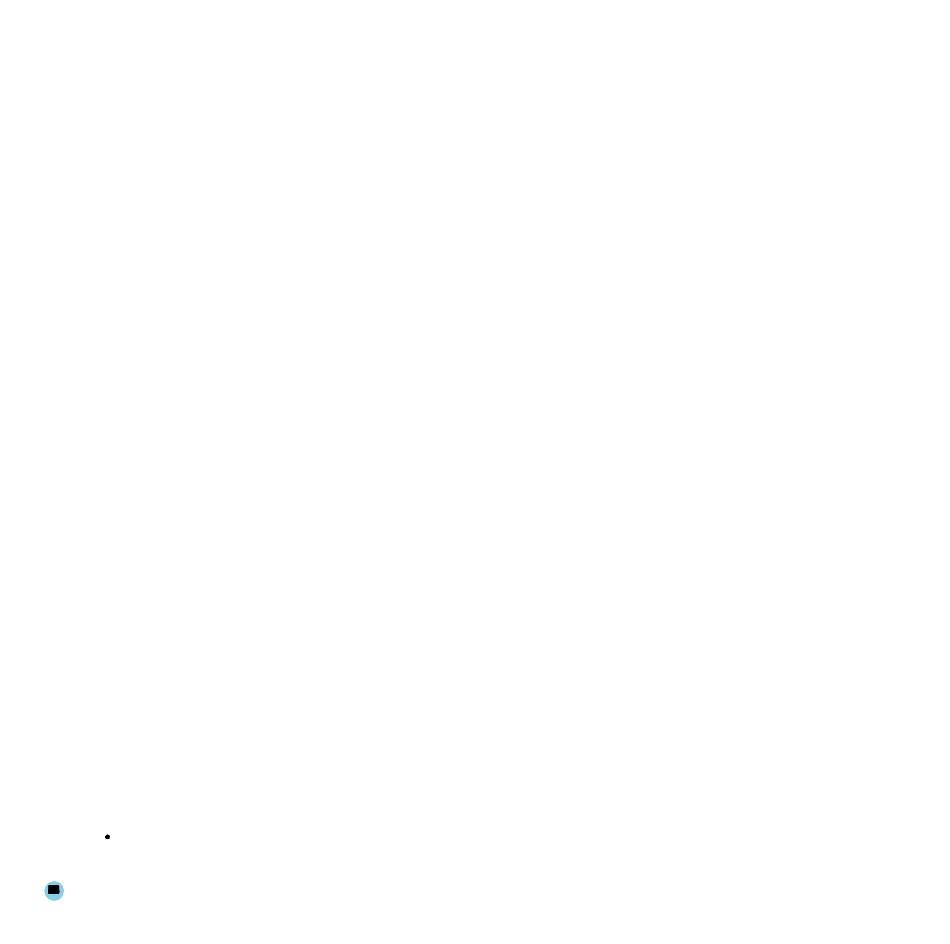

In [13]:
# Create a Matplotlib figure and axis with a larger size
fig, ax = plt.subplots(figsize=(12, 12))

# Choose a different layout algorithm (e.g., circular layout)
pos = nx.circular_layout(G)

# Plot the graph
nx.draw(G, pos, with_labels=True, node_size=100, node_color='skyblue', font_size=6, ax=ax)
labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels, font_size=6)

# Show the plot
plt.show()

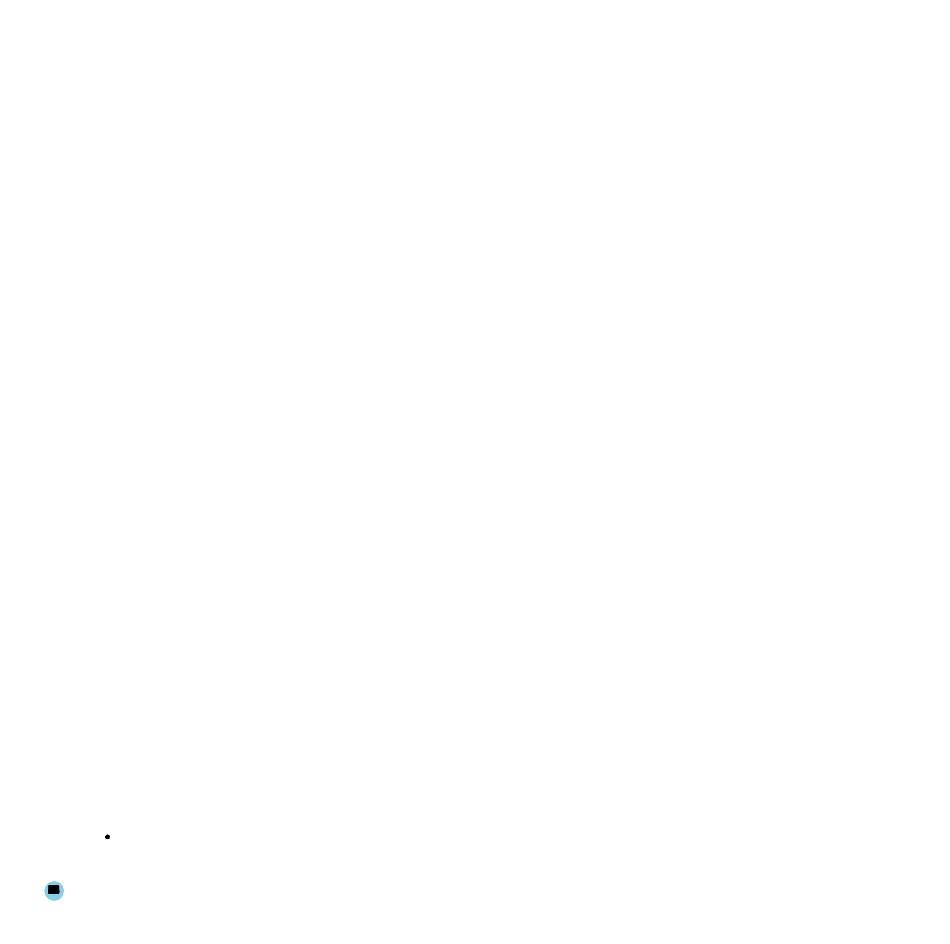